In [56]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, segmentation
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.io import imsave

In [52]:
# Load data
data = np.load('output/mip_mask.npy')  # Load your 3D neuron data

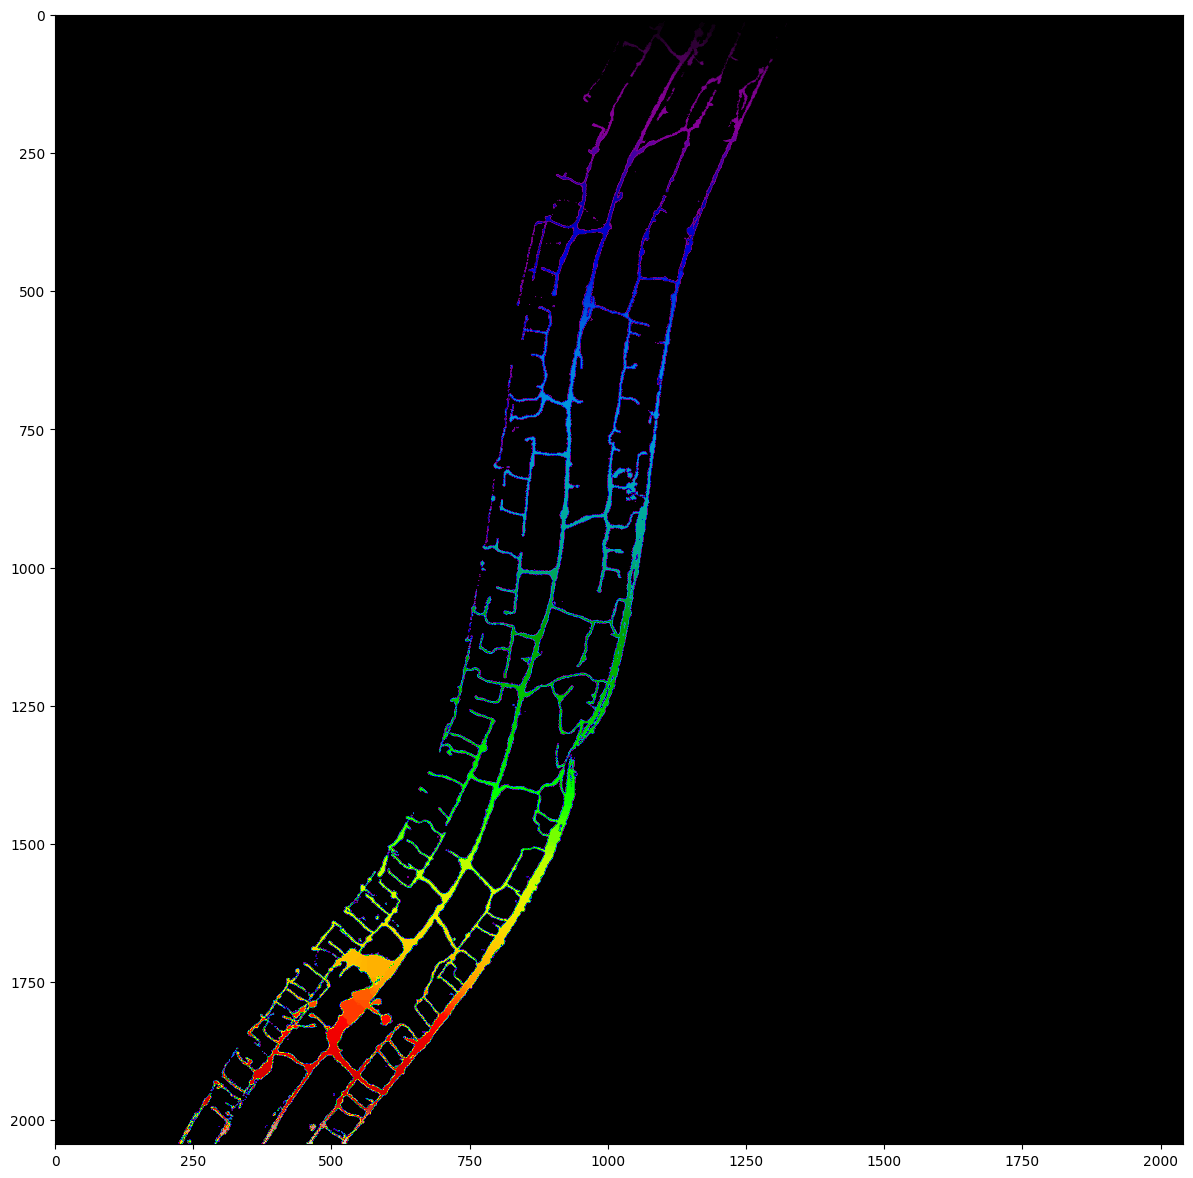

In [68]:
# Compute the distance transform
distance = ndi.distance_transform_edt(data)

# Find local maxima
local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=data)
markers = np.zeros_like(distance, dtype=bool)
markers[tuple(local_maxi.T)] = True

# Label the markers
markers, _ = ndi.label(markers)

# Perform marker-based watershed segmentation
labels = segmentation.watershed(-distance, markers, mask=data)

# Display the results
fig, axes = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)

#plt.imshow(data, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=1)


plt.tight_layout()
plt.show()

In [29]:
# output_path = 'segmented_neuron.tif'
# save_segmented_neuron(segmented_neuron, output_path)

### Watershed

In [94]:
# Apply a Gaussian filter to smooth the image
smoothed = filters.gaussian(data, sigma=1)

# Apply a threshold to the image
thresh = filters.threshold_otsu(smoothed)
binary = smoothed > thresh

# Compute the distance transform
distance = ndi.distance_transform_edt(binary)

# Find local maxima
local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
markers = np.zeros_like(distance, dtype=bool)
markers[tuple(local_maxi.T)] = True

# Label the markers
markers, _ = ndi.label(markers)

# Perform marker-based watershed segmentation
labels = segmentation.watershed(-distance, markers, mask=binary)

# Remove small objects
cleaned_labels = morphology.remove_small_objects(labels, min_size=20)

# Remove segments touching the image border
#cleaned_labels = segmentation.clear_border(labels)

In [95]:
print(len(cleaned_labels))

2044


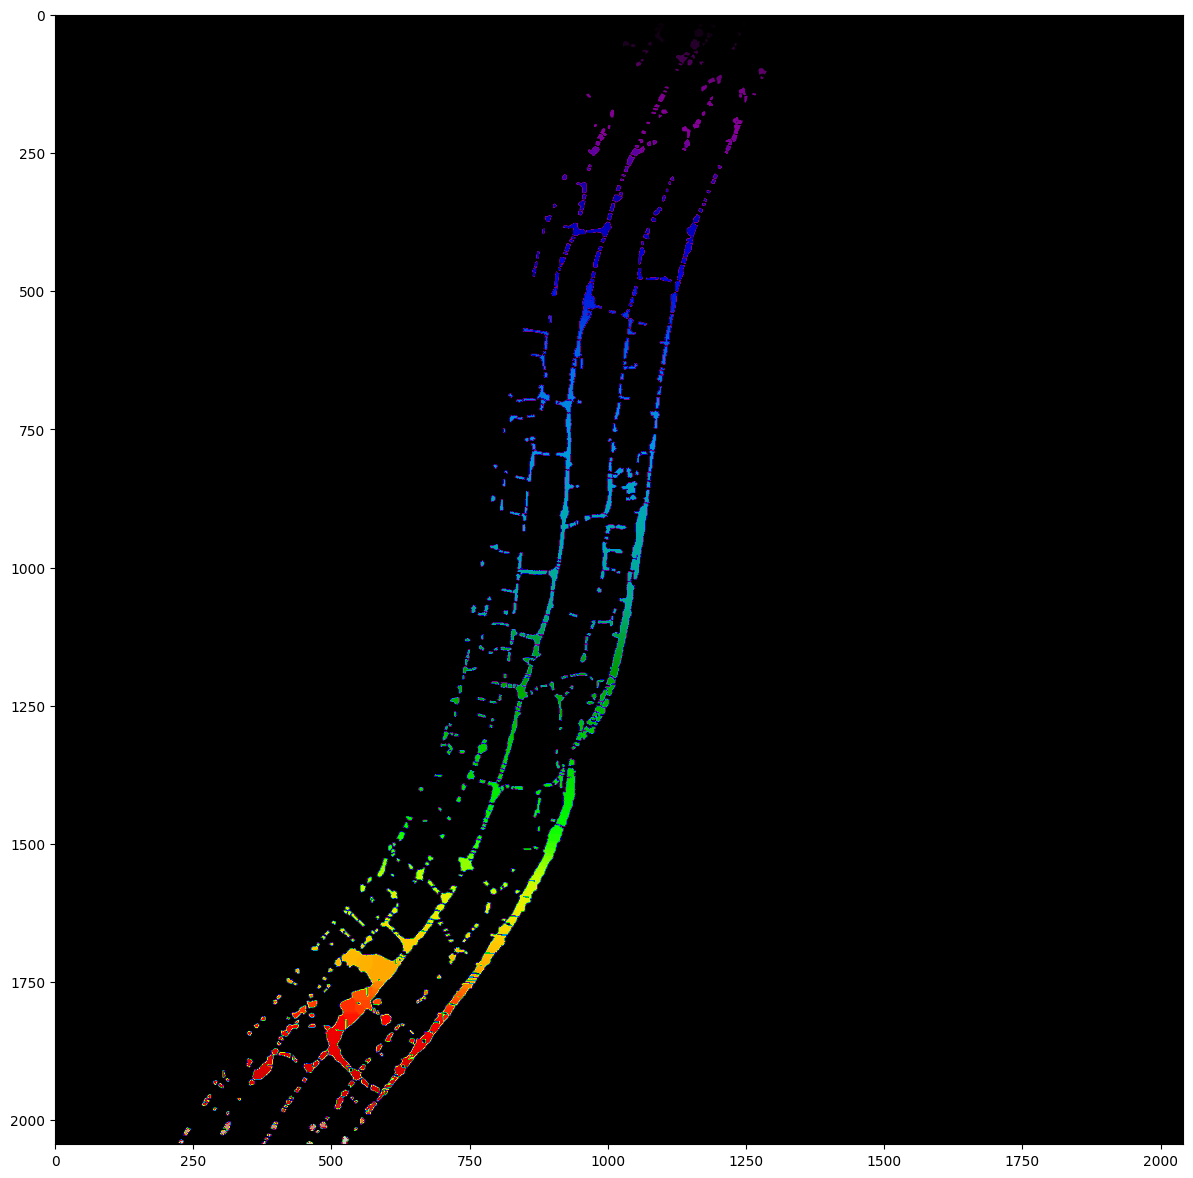

In [96]:
# Display the results
fig, axes = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)

#plt.imshow(data, cmap=plt.cm.gray)
plt.imshow(cleaned_labels, cmap=plt.cm.nipy_spectral, alpha=1)


plt.tight_layout()
plt.show()

### Medial Axis

In [91]:
# Apply a Gaussian filter to smooth the image
smoothed = filters.gaussian(data, sigma=2)

#Apply a threshold to the image
thresh = filters.threshold_otsu(smoothed)
binary = smoothed > thresh

In [92]:
skeleton, medial_distance = morphology.medial_axis(binary, return_distance=True)

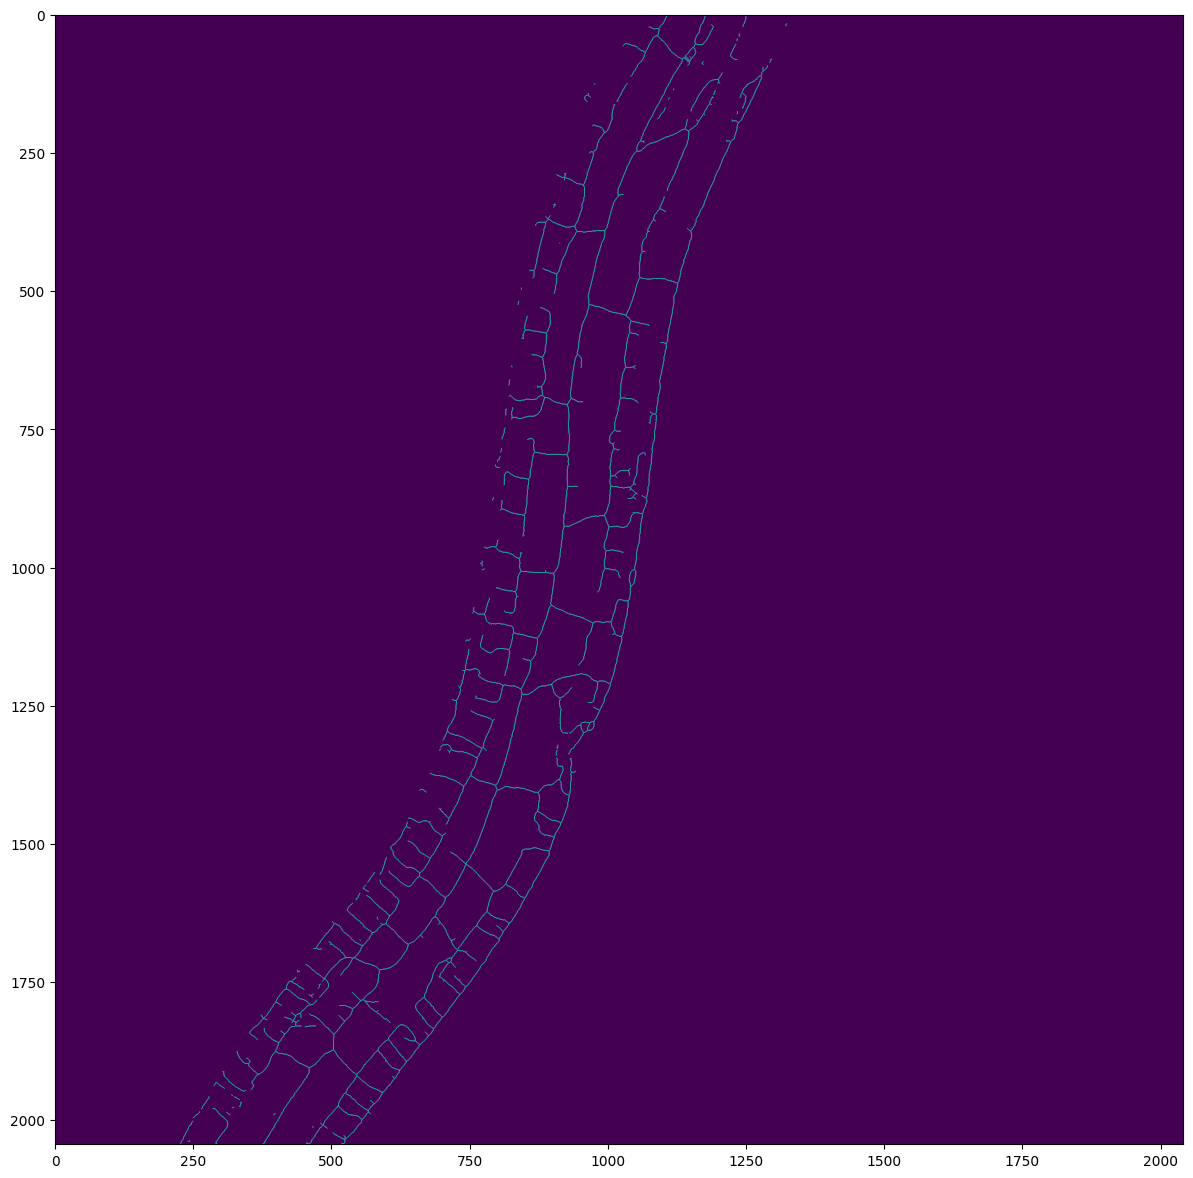

In [93]:
# Display the results
fig, axes = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)

#plt.imshow(data, cmap=plt.cm.gray)
plt.imshow(skeleton)


plt.tight_layout()
plt.show()

### Skeletonize

In [100]:
skeleton = morphology.skeletonize(binary, method='lee')

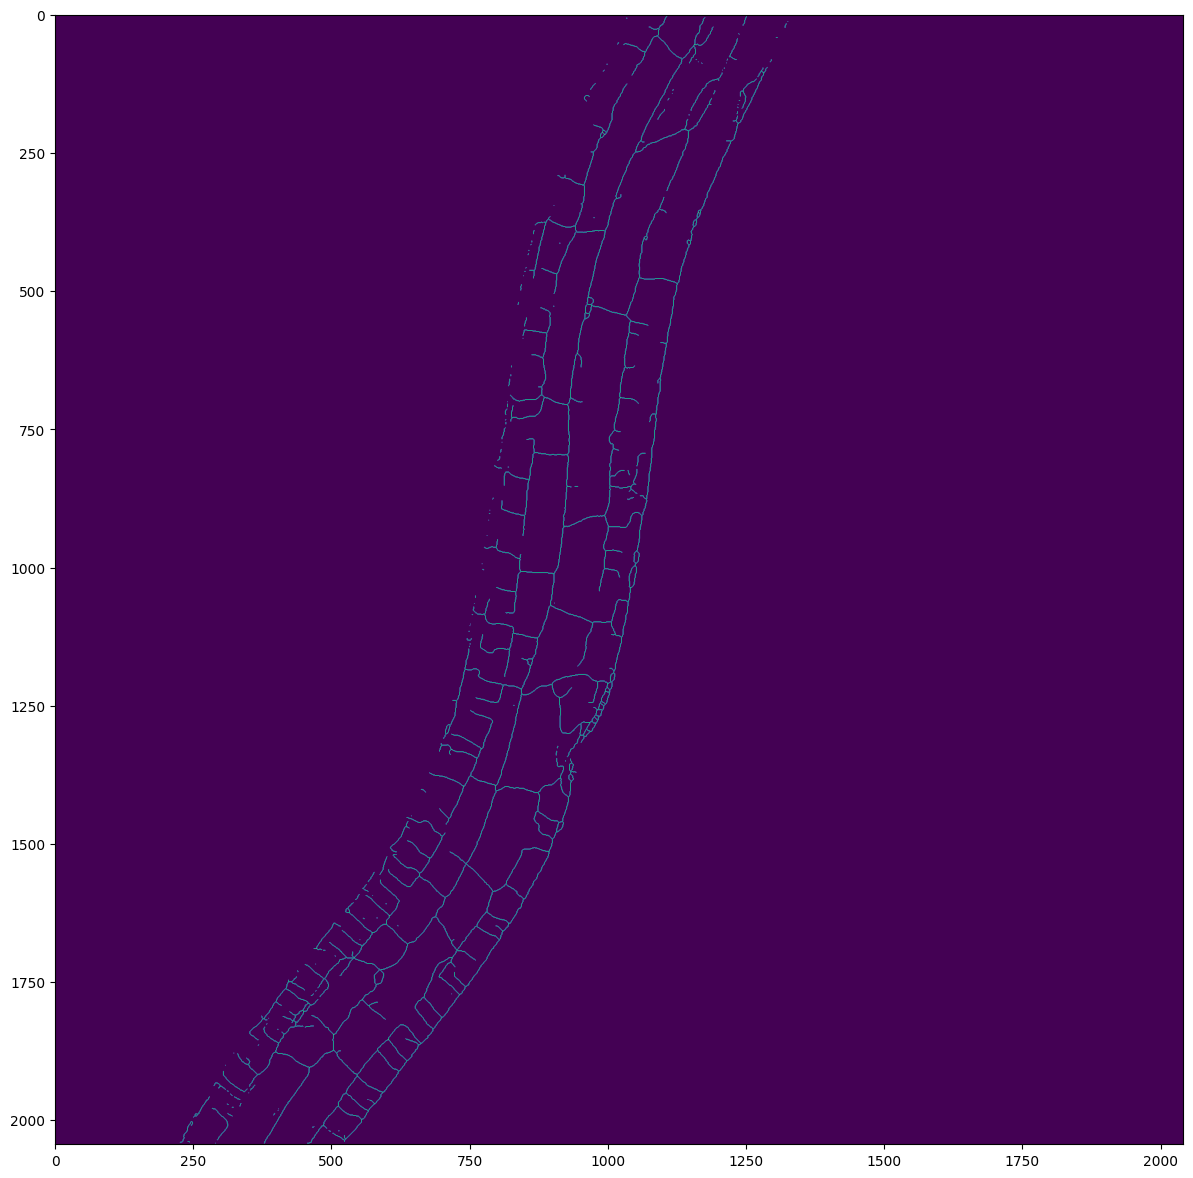

In [101]:
# Display the results
fig, axes = plt.subplots(1, 1, figsize=(12, 12), sharex=True, sharey=True)

#plt.imshow(data, cmap=plt.cm.gray)
plt.imshow(skeleton)


plt.tight_layout()
plt.show()

### 3D Skeleton

In [131]:
# Load data
data_3d = np.load('output/pvd_test.npy')  # Load your 3D neuron data

In [132]:
# Apply a Gaussian filter to smooth the image
smoothed = filters.gaussian(data_3d, sigma=2)

#Apply a threshold to the image
thresh = filters.threshold_otsu(smoothed)
binary = smoothed > thresh

skeleton_3d = morphology.skeletonize(smoothed, method='lee')

In [133]:
print(skeleton.shape)
print(f"min:{np.amin(skeleton_3d)} max:{np.amax(skeleton_3d)} type={type(skeleton_3d)}")


(188, 2044, 2042)
min:False max:True type=<class 'numpy.ndarray'>


In [134]:
import tifffile as tiff

tiff.imwrite('output/3d_skeleton.tif', ~skeleton_3d)

In [135]:
import plotly.graph_objects as go

# Prepare data for plotting
image_stack = np.transpose(skeleton_3d, (1, 2, 0))
x, y, z = image_stack.shape

Y, X, Z = np.meshgrid(np.arange(y), np.arange(x), np.arange(z))

colors = image_stack.ravel()  # Flatten the color intensity values

# Separate visible and invisible points
visible_mask = colors != 0

# Create a 3D scatter plot
fig = go.Figure()

# Visible points
fig.add_trace(go.Scatter3d(
    x=X.ravel()[visible_mask],
    y=Y.ravel()[visible_mask],
    z=Z.ravel()[visible_mask],
    mode='markers',
    marker=dict(
        size=2,
        color=colors[visible_mask],  # Color based on intensity
        colorscale='Viridis',
        opacity=1
    )
))

# Update layout for better viewing
fig.update_layout(
    title='3D Scatter Plot of Image Stack with Conditionally Invisible Points',
    scene=dict(
        xaxis_title='X (pixels)',
        yaxis_title='Y (pixels)',
        zaxis_title='Z (image index)',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.1)  # Adjust z-axis scale; modify as needed
    ),
    autosize=False,
    width=800,
    height=600
)

# Show the figure
fig.show()